In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis import network as net
import json
from os import listdir
import requests
import io


import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import hammer_bundle

In [2]:
pd.options.display.max_columns = None

In [3]:
nodes_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-nodes.csv" 
edges_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-edges.csv"

In [4]:
nodes = pd.read_csv(nodes_url)
edges = pd.read_csv(edges_url)

In [5]:
omitted_organs = ['muscular_system', 'skeleton'] + ['lymph_vasculature', 'peripheral_nervous_system', 'blood_pelvis',] 


nodes = nodes[~nodes['organ'].isin(omitted_organs)]
edges = edges[~edges['organ'].isin(omitted_organs)]

In [6]:
edges

organ                source  \
0      blood_vasculature        UBERON:0013702   
1            allen_brain        UBERON:0013702   
3            bone_marrow        UBERON:0013702   
4                    eye        UBERON:0013702   
5         fallopian_tube        UBERON:0013702   
...                  ...                   ...   
11905             uterus  UBERON:0011949$$8694   
11906             uterus  UBERON:0002451$$8696   
11907             uterus  UBERON:0002451$$8696   
11908             uterus  UBERON:0012276$$8697   
11909             uterus  UBERON:0011949$$8699   

                                           target source_type target_type  
0                                  UBERON:0000948          AS          AS  
1                                  UBERON:0000955          AS          AS  
3                                  UBERON:0002371          AS          AS  
4                                  UBERON:0000970          AS          AS  
5                                  UBERON:0003889          AS          AS  
...                                           ...         ...         ...  
11905    ASCTB-TEMP:luminal-epithelial-cell$$8695          AS          CT  
11906                        UBERON:0012276$$8697          AS          AS  
11907                        UBERON:0011949$$8699          AS          AS  
11908  ASCTB-TEMP:glandular-epithelial-cell$$8698          AS          CT  
11909    ASCTB-TEMP:luminal-epithelial-cell$$8700          AS          CT  

[11880 rows x 5 columns]

In [7]:
edges['organ'].value_counts()

organ
blood_vasculature    4531
ovary                2070
large_intestine      1333
allen_brain           868
uterus                696
heart                 259
lung                  206
small_intestine       181
spleen                179
pancreas              175
fallopian_tube        174
placenta              166
kidney                157
lymph_node            128
spinal_cord           127
thymus                106
eye                   103
skin                   74
palatine_tonsil        70
bone_marrow            50
liver                  48
trachea                37
prostate               34
urinary_bladder        32
knee                   29
main_bronchus          26
ureter                 21
Name: count, dtype: int64

In [8]:
nodes.duplicated(subset=['id', 'type', 'organ', 'ontology_id']).sum()

0

In [9]:
nodes.duplicated(subset=['id'], keep=False).sum()

0

In [10]:
def get_nodes(name=None, ontology_id=None):
    if name:
        return nodes[nodes['name'].str.lower()==name.lower()]
    if ontology_id:
        return nodes[nodes['ontology_id']==ontology_id]   

In [11]:
get_nodes(name='body')

id  name type organ     ontology_id
0  UBERON:0013702  body   AS  body  UBERON:0013702

In [12]:
get_nodes(ontology_id='UBERON:0013702')

id  name type organ     ontology_id
0  UBERON:0013702  body   AS  body  UBERON:0013702

In [13]:
whole_graph = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr=True)

In [14]:
nx.is_tree(whole_graph)

True

In [15]:
nodes

id  \
0                                  UBERON:0013702   
1                                  UBERON:0000948   
2                                  UBERON:0002079   
3                                      CL:0010008   
4                                       FMA:49913   
...                                           ...   
11906                        UBERON:0002451$$8696   
11907                        UBERON:0012276$$8697   
11908  ASCTB-TEMP:glandular-epithelial-cell$$8698   
11909                        UBERON:0011949$$8699   
11910    ASCTB-TEMP:luminal-epithelial-cell$$8700   

                                   name type              organ  \
0                                  body   AS               body   
1                                 heart   AS  blood_vasculature   
2                   left cardiac atrium   AS  blood_vasculature   
3              cardiac endothelial cell   CT  blood_vasculature   
4          Left inferior pulmonary vein   AS  blood_vasculature   
...                                 ...  ...                ...   
11906                 endometrial gland   AS             uterus   
11907  endometrium glandular epithelium   AS             uterus   
11908         glandular epithelial cell   CT             uterus   
11909    endometrium luminal epithelium   AS             uterus   
11910           luminal epithelial cell   CT             uterus   

                                ontology_id  
0                            UBERON:0013702  
1                            UBERON:0000948  
2                            UBERON:0002079  
3                                CL:0010008  
4                                 FMA:49913  
...                                     ...  
11906                        UBERON:0002451  
11907                        UBERON:0012276  
11908  ASCTB-TEMP:glandular-epithelial-cell  
11909                        UBERON:0011949  
11910    ASCTB-TEMP:luminal-epithelial-cell  

[11881 rows x 5 columns]

In [16]:
nodes.isna().sum()

id             0
name           1
type           0
organ          0
ontology_id    0
dtype: int64

In [17]:
organ_order = ['trachea', 'main bronchus', 'respiratory system', 'heart',  'spinal cord', 'brain', 'eye', 'palatine tonsil', 
               'skin of body', 'thymus', 'lymph node', 'spleen',  'liver', 'Pancreas', 'small intestine',  'large intestine', 
               'kidney', 'urinary bladder', 'ureter', 'prostate gland',  'ovary', 'fallopian tube', 'uterus',  
               'placenta', 'knee', 'Bone marrow']

# Nodes that are branching from the 'body' node

In [18]:
nodes[nodes['ontology_id'].isin(list(nx.neighbors(whole_graph, 'UBERON:0013702')))]

id                       name type              organ  \
1      UBERON:0000948                      heart   AS  blood_vasculature   
4535   UBERON:0000955                      brain   AS        allen_brain   
5433   UBERON:0002371                Bone marrow   AS        bone_marrow   
5483   UBERON:0000970                        eye   AS                eye   
5586   UBERON:0003889             fallopian tube   AS     fallopian_tube   
6016   UBERON:0002113                     kidney   AS             kidney   
6173   UBERON:0001465                       knee   AS               knee   
6202   UBERON:0000059            large intestine   AS    large_intestine   
7535   UBERON:0002107                      liver   AS              liver   
7583   UBERON:0001004         respiratory system   AS               lung   
7737   UBERON:0008886  pulmonary vascular system   AS               lung   
7748   UBERON:0004573            systemic artery   AS               lung   
7754   UBERON:0003920        venous blood vessel   AS               lung   
7789   UBERON:0000029                 lymph node   AS         lymph_node   
7917   UBERON:0002182              main bronchus   AS      main_bronchus   
7951   UBERON:0000992                      ovary   AS              ovary   
10021  UBERON:0002373            palatine tonsil   AS    palatine_tonsil   
10091  UBERON:0001264                   Pancreas   AS           pancreas   
10266  UBERON:0001987                   placenta   AS           placenta   
10432  UBERON:0002367             prostate gland   AS           prostate   
10466  UBERON:0002097               skin of body   AS               skin   
10540  UBERON:0002108            small intestine   AS    small_intestine   
10721  UBERON:0002240                spinal cord   AS        spinal_cord   
10848  UBERON:0002106                     spleen   AS             spleen   
11027  UBERON:0002370                     thymus   AS             thymus   
11133  UBERON:0003126                    trachea   AS            trachea   
11162  UBERON:0000056                     ureter   AS             ureter   
11183  UBERON:0001255            urinary bladder   AS    urinary_bladder   
11215  UBERON:0000995                     uterus   AS             uterus   

          ontology_id  
1      UBERON:0000948  
4535   UBERON:0000955  
5433   UBERON:0002371  
5483   UBERON:0000970  
5586   UBERON:0003889  
6016   UBERON:0002113  
6173   UBERON:0001465  
6202   UBERON:0000059  
7535   UBERON:0002107  
7583   UBERON:0001004  
7737   UBERON:0008886  
7748   UBERON:0004573  
7754   UBERON:0003920  
7789   UBERON:0000029  
7917   UBERON:0002182  
7951   UBERON:0000992  
10021  UBERON:0002373  
10091  UBERON:0001264  
10266  UBERON:0001987  
10432  UBERON:0002367  
10466  UBERON:0002097  
10540  UBERON:0002108  
10721  UBERON:0002240  
10848  UBERON:0002106  
11027  UBERON:0002370  
11133  UBERON:0003126  
11162  UBERON:0000056  
11183  UBERON:0001255  
11215  UBERON:0000995

In [20]:
new_edges = edges[(edges['source']=='UBERON:0013702')&(edges['target'].isin(['UBERON:0008886', 'UBERON:0004573', 'UBERON:0003920']))].copy()
new_edges['source'].replace('UBERON:0013702', 'UBERON:0001004', inplace=True) #connect the nodes to respiratory system instead of body

C:\Users\admin\AppData\Local\Temp\ipykernel_39652\598928270.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_edges['source'].replace('UBERON:0013702', 'UBERON:0001004', inplace=True) #connect the nodes to respiratory system instead of body


In [21]:
new_edges

organ          source          target source_type target_type
11  lung  UBERON:0001004  UBERON:0008886          AS          AS
12  lung  UBERON:0001004  UBERON:0004573          AS          AS
13  lung  UBERON:0001004  UBERON:0003920          AS          AS

In [22]:
edges = edges[~((edges['source']=='UBERON:0013702')&(edges['target'].isin(['UBERON:0008886', 'UBERON:0004573', 'UBERON:0003920'])))]
edges = pd.concat([edges, new_edges])

In [23]:
whole_graph = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr=True)

In [24]:
nx.is_tree(whole_graph)

True

In [26]:
organ_order_in_id = [get_nodes(name=organ)['id'].values[0] for organ in organ_order]

In [27]:
len(organ_order_in_id)

26

In [29]:
def get_organ_graph(organ_id):
    organ_graph = whole_graph.copy()
    organ_graph.remove_edge('UBERON:0013702', organ_id) #remove the edge between body and the organ

    connected_components = sorted(list(nx.connected_components(organ_graph)), key=len, reverse=False) #get the connected components

    return nx.subgraph(organ_graph, connected_components[0]) #return the smallest connected component

In [31]:
nodes[nodes['name']=='knee']

id  name type organ     ontology_id
6173  UBERON:0001465  knee   AS  knee  UBERON:0001465

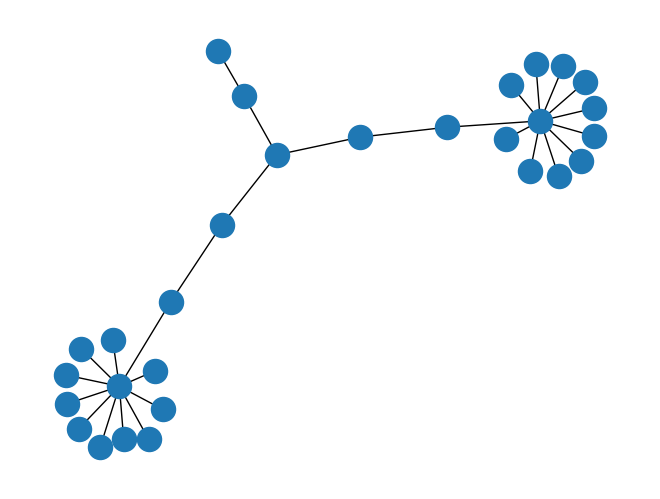

In [34]:
nx.draw(get_organ_graph('UBERON:0001465'))

## Generate a new integer-based ID, that takes into account the organ order
(This is necesary for the layout, later we can order the nodes and edges based on this integer ID, and then vega will visualize the organs in the desired order)

In [35]:
id_to_graph_int_id = {'UBERON:0013702': 0}

next_id = 1

for i, organ_id in enumerate(organ_order_in_id):
    branch_graph = get_organ_graph(organ_id)

    branch_graph_new_ids = dict(zip(nx.dfs_preorder_nodes(branch_graph, source=organ_id), range(next_id, next_id+branch_graph.number_of_nodes())))

    id_to_graph_int_id.update(branch_graph_new_ids)

    next_id += branch_graph.number_of_nodes()


In [42]:
nodes['graph_int_id'] = nodes['id'].map(id_to_graph_int_id)

In [46]:
nodes.head()

id                          name type              organ  \
0  UBERON:0013702                          body   AS               body   
1  UBERON:0000948                         heart   AS  blood_vasculature   
2  UBERON:0002079           left cardiac atrium   AS  blood_vasculature   
3      CL:0010008      cardiac endothelial cell   CT  blood_vasculature   
4       FMA:49913  Left inferior pulmonary vein   AS  blood_vasculature   

      ontology_id  graph_int_id  
0  UBERON:0013702             0  
1  UBERON:0000948           262  
2  UBERON:0002079           263  
3      CL:0010008           264  
4       FMA:49913           265

In [44]:
edges['source_int'] = edges['source'].map(id_to_graph_int_id)
edges['target_int'] = edges['target'].map(id_to_graph_int_id)

In [45]:
edges.head()

organ          source          target source_type target_type  \
0  blood_vasculature  UBERON:0013702  UBERON:0000948          AS          AS   
1        allen_brain  UBERON:0013702  UBERON:0000955          AS          AS   
3        bone_marrow  UBERON:0013702  UBERON:0002371          AS          AS   
4                eye  UBERON:0013702  UBERON:0000970          AS          AS   
5     fallopian_tube  UBERON:0013702  UBERON:0003889          AS          AS   

   source_int  target_int  
0           0         262  
1           0        5187  
3           0       11831  
4           0        6055  
5           0       10766

In [47]:
whole_graph_int = nx.from_pandas_edgelist(edges, source='source_int', target='target_int', edge_attr=True)

In [48]:
graph_int_id_to_id = {v: k for k, v in id_to_graph_int_id.items()}

In [49]:
id_to_graph_int_id['UBERON:0013702']

0

In [50]:
graph_int_id_to_id[0]

'UBERON:0013702'

In [51]:
get_nodes(name='body')

id  name type organ     ontology_id  graph_int_id
0  UBERON:0013702  body   AS  body  UBERON:0013702             0

In [54]:
# layout_pos_full_neato = nx.drawing.nx_agraph.graphviz_layout(whole_graph_int)

In [57]:
layout_pos_full_twopi = nx.drawing.nx_agraph.graphviz_layout(whole_graph_int, prog='twopi')

In [53]:
# plt.figure(figsize=(13,13))
# nx.draw(whole_graph_int, pos=layout_pos_full_twopi, node_size=4, width=0.1, edge_color='gray', alpha=0.5)
# nx.draw_networkx_nodes(blood_graph_int, pos=layout_pos_full_twopi, node_size=10, node_color='tab:red', alpha=.3)
# nx.draw_networkx_edges(blood_graph_int, pos=layout_pos_full_twopi, edge_color='tab:red', width=0.1, alpha=0.5)
# # nx.draw_networkx_nodes(vasc_graph, layout_pos_full, 
# #                        nodelist=matching_nodes_in_blood_vasc['id'].tolist(), 
# #                        node_size=10, node_color='tab:orange', )
# plt.show()

# Removal of the blood vasculature nodes from the whole (partonomy) graph
We only keep those that are necessary to keep the network connected

In [54]:
# remove those blood nodes from the graph, which if we remove, the graph will be still connected, repeat until no such node is found.
blood_nodes_candidates = set(nodes[nodes['organ']=='blood_vasculature'].graph_int_id.tolist())

distance_from_body = nx.single_source_shortest_path_length(whole_graph_int, source=0)

distance_from_body_blood_nodes = {k: v for k, v in distance_from_body.items() if k in blood_nodes_candidates}

node_visiting_order = sorted(distance_from_body_blood_nodes.items(), key=lambda x: x[1], reverse=True)

new_truncated_graph = whole_graph_int.copy()

for node in node_visiting_order:
    new_truncated_graph.remove_node(node[0])
    if nx.is_connected(new_truncated_graph):
        blood_nodes_candidates.remove(node[0])
    else:
        break


In [55]:
nodes['keep'] = nodes.apply(lambda row: True if (row['organ']!='blood_vasculature' or row['graph_int_id'] in blood_nodes_candidates) else False, axis=1)

In [56]:
truncated_nodes = nodes[nodes['keep']]
truncated_edges = edges[edges['source_int'].isin(truncated_nodes['graph_int_id']) | edges['target_int'].isin(truncated_nodes['graph_int_id'])]
truncated_graph = nx.from_pandas_edgelist(truncated_edges, source='source_int', target='target_int', edge_attr=True)

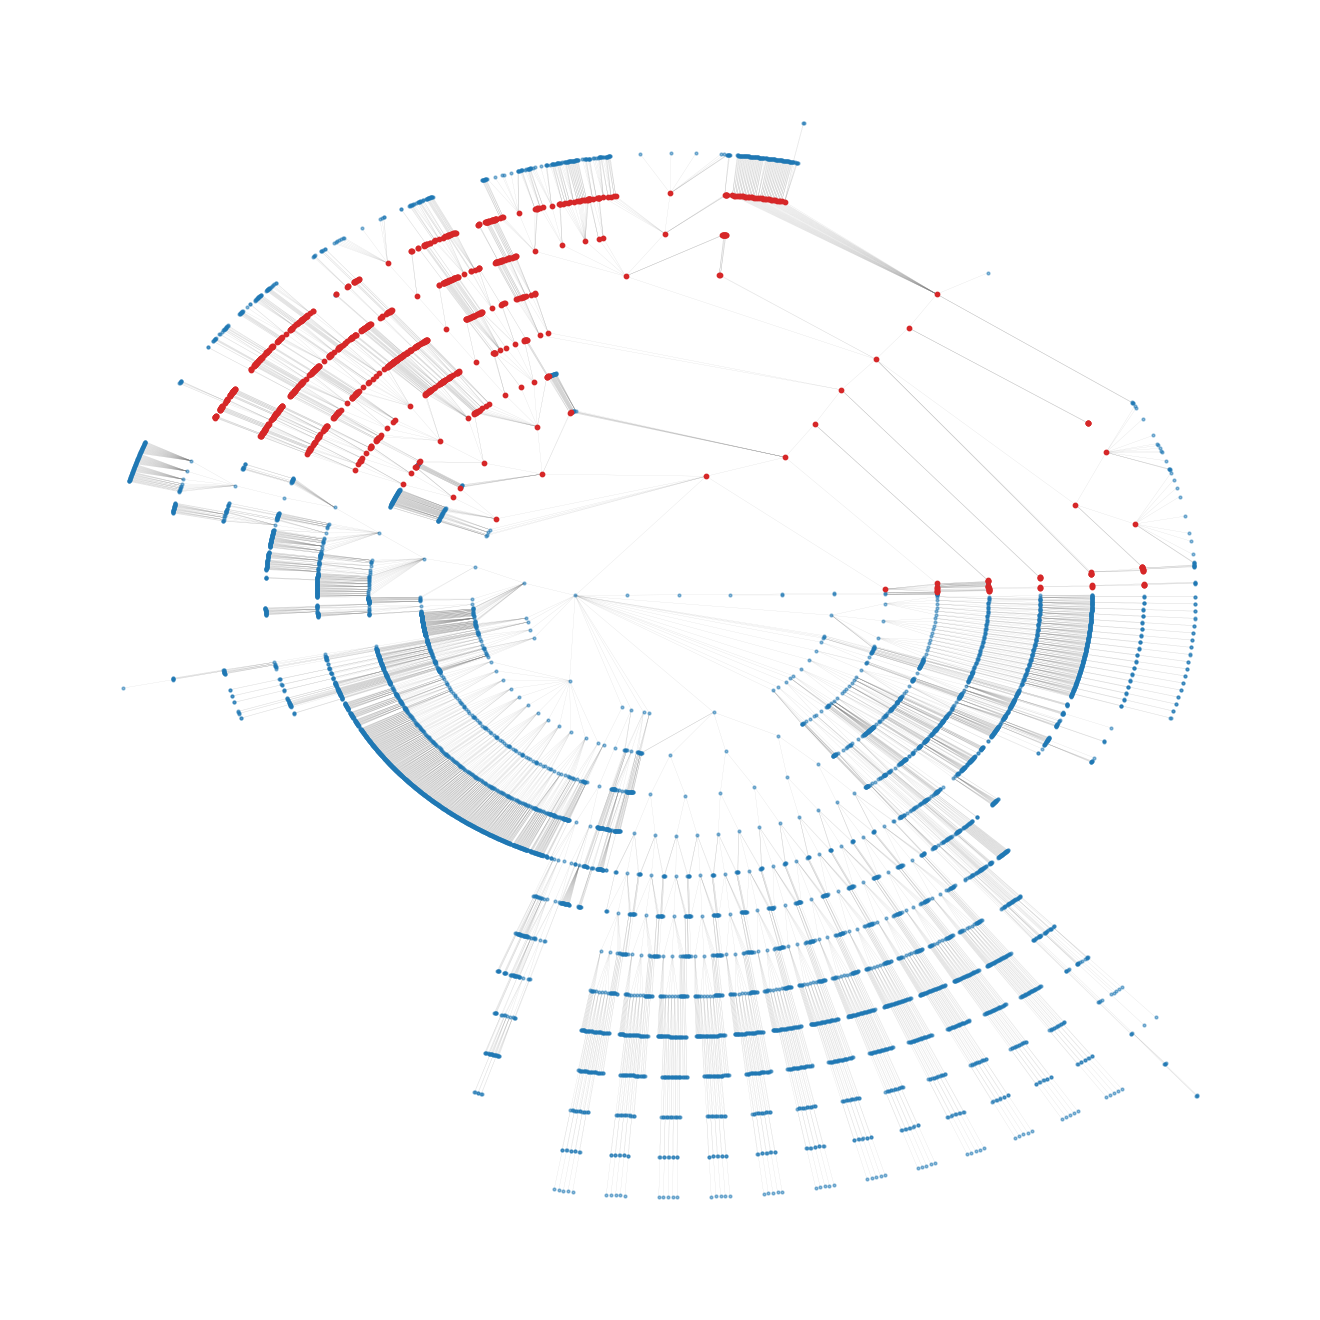

In [58]:
plt.figure(figsize=(13,13))
nx.draw(truncated_graph, pos=layout_pos_full_twopi, node_size=4, width=0.1, edge_color='gray', alpha=0.5)
# nx.draw_networkx_nodes(blood_graph_int, pos=layout_pos_full_twopi, node_size=10, node_color='tab:red', alpha=.9)
# nx.draw_networkx_edges(blood_graph_int, pos=layout_pos_full_twopi, edge_color='tab:red', width=0.1, alpha=0.5)
nx.draw_networkx_nodes(truncated_graph, pos=layout_pos_full_twopi, 
                       nodelist=truncated_nodes[truncated_nodes['organ']=='blood_vasculature']['graph_int_id'].tolist(),
                       node_size=10, node_color='tab:red', )
plt.show()

In [61]:
# dropped_nodes = [node for node in whole_graph_int.nodes() if node not in truncated_graph.nodes()]
# len(dropped_nodes)

In [62]:
# nodes[nodes['graph_int_id'].isin(dropped_nodes)].organ.value_counts()

In [63]:
FTUs = ['UBERON:0001285', 'UBERON:0001229', 'UBERON:0004205', 'UBERON:0001289', 'UBERON:0004193', 'UBERON:0004204', 'UBERON:0001291', 'UBERON:0004203', #kidney
        'UBERON:0001983',  'UBERON:0001984',  #large intestine
        'UBERON:0004647', #liver
        'UBERON:0002299', 'UBERON:8410043', #lung 
        'UBERON:0000006', 'UBERON:0001263', 'UBERON:0014726', #pancreas
        'UBERON:0004179', #prostate gland
        'UBERON:0000412', 'UBERON:0013487', 'UBERON:0001992', #skin
        'UBERON:0001213', #small intestine
        'UBERON:0001250', 'UBERON:0001959', #spleen
        'UBERON:0002125' 
        ]

In [64]:
def construct_network_create_vega_viz(nodes_dataframe, edges_dataframe, filename='butterfly', only_female=False, only_male=False, scenegraph=False, show_labels=False):
    '''
    Construct the network and create the vega visualization file, which is a JSON file. 
    Vega will visualize the network based on the config file. Using the API we can create the SVG and the "scenegraph" which will be used for the coordinates of the nodes.

    Parameters:
    nodes_dataframe: pd.DataFrame
        The dataframe containing the nodes of the network. It should have the following columns: 'id', 'name', 'type', 'organ', 'ontology_id', 'graph_int_id'.
    edges_dataframe: pd.DataFrame
        The dataframe containing the edges of the network. It should have the following columns: 'source_int', 'target_int', 'organ'.
    filename: str
        The name of the file to be saved
    only_female: bool
        If True, the visualization will not contain the prostate (so far that's the only male organ).
    only_male: bool
        If True, the visualization will not contain the ovaries, fallopian tube, uterus, placenta (so far these are the female organs).
    scenegraph: bool
        If True, the name of the nodes will be the id of the nodes. This is necessary to later get the coordinates of the nodes based on the IDs.
    show_labels: bool
        If True, the labels of the nodes will be shown (in the SVG file).
    '''

    nodes_df = nodes_dataframe.sort_values('graph_int_id').copy() 
    edges_df = edges_dataframe.sort_values('target_int').copy() #sorting is necessary for the order of the branches in the visualization

    # create the graph
    graph = nx.from_pandas_edgelist(edges_df, source='source_int', target='target_int', edge_attr=True)

    # get the parent of each node for the tree layout
    parents_dict = dict(nx.bfs_predecessors(graph, source=0))

    nodes_df['parent'] = nodes_df['graph_int_id'].map(parents_dict).fillna(0).astype(int)

    # set the color of the nodes based on the type
    nodes_df['color'] = nodes_df.apply(lambda row: '#56a04e' if row['ontology_id'] in FTUs else ('#984ea0' if row['type']=='AS' else '#ff7f00'), axis=1)


    # vega works with the id column, so we rename the id column to id_from_ontology_id
    nodes_df.rename(columns={'id': 'id_from_ontology_id', 'graph_int_id': 'id'}, inplace=True)
    

    if scenegraph:
        # the name has to be the id
        nodes_df.rename(columns={'name': 'name_label'}, inplace=True)
        nodes_df['name'] = nodes_df['id'].copy()


    # if the name is missing, we fill it with an empty string because vega gives an error if it is missing
    nodes_df['name'] = nodes_df['name'].fillna('')



    # from the female wing we remove the prostate
    if only_female and not only_male:
        nodes_df = nodes_df[nodes_df['organ']!='prostate']
        fn = filename + '_female'

    # from the male wing we remove the ovaries, fallopian tube, uterus, placenta
    elif only_male and not only_female:
        nodes_df = nodes_df[~nodes_df['organ'].isin(['fallopian_tube', 'ovary', 'uterus', 'placenta'])]
        fn = filename + '_male'

    elif not only_female and not only_male:
        fn = filename + '_full'

    else:
        raise ValueError('The parameters `only_female` and `only_male` cannot be both True at the same time.')

    # print(nodes_df['organ'].value_counts())

    # create the json file for the nodes
    nodes_json = nodes_df[['id', 'name', 'parent', 'type', 'ontology_id', 
                           'id_from_ontology_id', 'color', 'organ', #'organ_label'
                           ]].to_dict(orient='index')

    # the body does not have a parent, so we delete its value
    del(nodes_json[0]['parent'])

    # we need to convert the dictionary to a list, that's how the vega visualization expects it at the config['data'][0]['values']
    nodes_json = [nodes_json[i] for i in nodes_json.keys()]
    
    # load the vega config file
    with open('viz_v2.0/vega_config/vega_config.json', encoding='utf8') as json_file:
        config = json.load(json_file)

    # set the data in the config file
    config['data'][0]['values'] = nodes_json
    
    # show labels if show_labels is True
    if show_labels:
        config['marks'][-1]['encode']['update']['opacity']['signal'] = config['marks'][-1]['encode']['update']['opacity']['signal'][:-1] + '1' # show the labels, by default they are hidden
    
    # create the json file and save it
    with open(f"viz_v2.0/{fn}_vega_viz_config.json", "w") as outfile:
        outfile.write(json.dumps(config, indent=4))
        print(f'File saved as "viz_v2.0/{fn}_vega_viz.json"')
    
    return config

In [65]:
vega_config = construct_network_create_vega_viz(truncated_nodes, truncated_edges, scenegraph=True)

File saved as "viz_v2.0/butterfly_full_vega_viz.json"


In [66]:
vega_config_female_with_names = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=False, show_labels=True, filename='butterfly_names') #name shown - this one is not used just for manual checking with human readable names
vega_config_female_with_ids = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=True, show_labels=True, filename='butterfly_ids') #id shown - this is used for the coordinates 
vega_config_female = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=True, show_labels=False) #no name or id shown, based on id (scenegraph) - this is used for the viz

File saved as "viz_v2.0/butterfly_names_female_vega_viz.json"
File saved as "viz_v2.0/butterfly_ids_female_vega_viz.json"
File saved as "viz_v2.0/butterfly_female_vega_viz.json"


In [67]:
vega_config_male = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_male=True, scenegraph=True)

vega_config_male_with_ids = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_male=True, scenegraph=True, show_labels=True, filename='butterfly_ids') #id shown - this is used for the coordinates 


File saved as "viz_v2.0/butterfly_male_vega_viz.json"
File saved as "viz_v2.0/butterfly_ids_male_vega_viz.json"


In [68]:
import vl_convert as vlc

In [69]:
def create_vega_viz(config, filename, scenegraph=False):
    '''
    Create the visualization based on the vega config file. The visualization can be saved as SVG or as a scenegraph JSON file.

    Parameters:
    config: dict
        The vega config file.
    filename: str
        The name of the file to be saved.
    scenegraph: bool
        If True, the scenegraph JSON file will be saved, otherwise the SVG file will be saved.
    '''

    if scenegraph:
        scenegraph_data = vlc.vega_to_scenegraph(vg_spec=config)

        with open(f"viz_v2.0/vega_{filename}_scenegraph.json", "w") as outfile:
            outfile.write(json.dumps(scenegraph_data, indent=4))

        return scenegraph_data
    
    else:
        svg_str = vlc.vega_to_svg(vg_spec=config,)

        with open(f"viz_v2.0/vega_{filename}_viz.svg", "wt") as f:
            f.write(svg_str)

        return svg_str

In [70]:
%%time
female_svg_ids = create_vega_viz(vega_config_female_with_ids, 'female_id', scenegraph=False)

CPU times: total: 6.55 s
Wall time: 10.3 s


In [71]:
%%time
female_svg_names = create_vega_viz(vega_config_female_with_names, 'female_name', scenegraph=False)

CPU times: total: 25.8 s
Wall time: 41.9 s


In [72]:
%%time
female_svg = create_vega_viz(vega_config_female, 'female', scenegraph=False)

CPU times: total: 4.69 s
Wall time: 10.4 s


In [352]:
%%time
male_svg = create_vega_viz(vega_config_male, 'male', scenegraph=False)

CPU times: total: 3.88 s
Wall time: 6.34 s


In [73]:
# display the female_svg that is an SVG image in string format

from IPython.display import SVG, display

display(SVG(female_svg_names))


In [74]:
scenegraph_female = create_vega_viz(vega_config_female_with_ids, 'female_id', scenegraph=True)
scenegraph_male = create_vega_viz(vega_config_male_with_ids, 'male_id', scenegraph=True)

In [75]:
def get_node_coordinates(scenegraph):
    return {item['text']: (item['x'], item['y']) for item in scenegraph['scenegraph']['items'][0]['items'][2]['items']}

In [76]:
coordinates_of_nodes_fem = get_node_coordinates(scenegraph_female)
coordinates_of_nodes_mal = get_node_coordinates(scenegraph_male)

In [77]:
coordinates_of_nodes_fem

{0: (860, 860),
 1: (876.341227877857, 800.4144416721647),
 2: (892.1576974720581, 740.6862101327795),
 3: (908.0614993790773, 680.9822280174445),
 4: (908.1490285496767, 681.0057502099978),
 5: (908.236546208087, 681.0293151991691),
 6: (908.3240523333836, 681.0529229793242),
 7: (908.4115469046445, 681.0765735448188),
 8: (892.3910008675883, 740.7493353394642),
 9: (908.5865013013824, 681.1240030091963),
 10: (924.7820017351766, 621.4986706789284),
 11: (892.682455755714, 740.8288833443294),
 12: (909.0236836335712, 681.243325016494),
 13: (925.0152123079711, 621.5621380625885),
 14: (941.1232684750487, 561.9129698278989),
 15: (941.2690153849638, 561.9526725782355),
 16: (941.4147428638694, 561.9924465901779),
 17: (925.4231810574576, 621.6737546616869),
 18: (941.7061393892852, 562.0722083608233),
 19: (941.851808366124, 562.1121961004558),
 20: (925.7144700591358, 621.7539081924288),
 21: (942.1430875739197, 562.1923852405359),
 22: (893.0028304304221, 740.9172088722956),
 23: (90

# Vasculature 

In [78]:
blood_edges_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-blood-vasculature-edges.csv"

blood_edges = pd.read_csv(blood_edges_url)

blood_graph = nx.from_pandas_edgelist(blood_edges, source='source', target='target', edge_attr=True,)# create_using=nx.DiGraph)

blood_nodes = nodes[nodes['id'].isin(blood_graph.nodes)]

blood_nodes['graph_int_id'] = blood_nodes['id'].map(id_to_graph_int_id)

blood_edges['source_int'] = blood_edges['source'].map(id_to_graph_int_id)
blood_edges['target_int'] = blood_edges['target'].map(id_to_graph_int_id)

C:\Users\admin\AppData\Local\Temp\ipykernel_39652\1614584421.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_nodes['graph_int_id'] = blood_nodes['id'].map(id_to_graph_int_id)


In [79]:
#edges in blood_graph that are not in whole graph:
new_edges = []
for edge in blood_graph.edges:
    if not whole_graph.has_edge(*edge):
        new_edges.append(edge)

In [80]:
len(new_edges)

344

In [81]:
blood_graph_int = nx.from_pandas_edgelist(blood_edges, source='source_int', target='target_int', edge_attr=True)

In [82]:
id_of_heart = blood_nodes[blood_nodes['name']=='heart']['graph_int_id'].values[0]

In [83]:
id_of_heart

262

In [84]:
blood_nodes[blood_nodes['graph_int_id'].isin(list(nx.neighbors(blood_graph_int, id_of_heart)))]

id                   name type              organ  \
2     UBERON:0002079    left cardiac atrium   AS  blood_vasculature   
37    UBERON:0002084   heart left ventricle   AS  blood_vasculature   
3236  UBERON:0002078   right cardiac atrium   AS  blood_vasculature   
4354  UBERON:0002080  heart right ventricle   AS  blood_vasculature   

         ontology_id  graph_int_id  keep  
2     UBERON:0002079           263  True  
37    UBERON:0002084           336  True  
3236  UBERON:0002078          3582  True  
4354  UBERON:0002080          4739  True

In [85]:
components = blood_graph_int.copy()
components.remove_node(id_of_heart)
components = list(nx.connected_components(components))

In [86]:
len(components)

4

In [87]:
components += [set([id_of_heart])]

In [88]:
id_of_left_ventricle_and_left_atrium = blood_nodes[blood_nodes['name'].apply(lambda x: 'left cardiac atrium' in str(x).lower() or 'left ventricle' in str(x).lower())]['graph_int_id'].tolist()

id_of_right_ventricle_and_right_atrium = blood_nodes[blood_nodes['name'].apply(lambda x: 'right cardiac atrium' in str(x).lower() or 'right ventricle' in str(x).lower())]['graph_int_id'].tolist()

In [89]:
id_of_left_ventricle_and_left_atrium

[263, 336]

In [90]:
id_of_right_ventricle_and_right_atrium

[3582, 4739]

In [91]:
blood_nodes['artery/vein'] = blood_nodes['graph_int_id'].apply(lambda x: 'artery' if set(id_of_left_ventricle_and_left_atrium+[id_of_heart]).intersection(set([comp for comp in components if x in comp][0])) else 'vein')

C:\Users\admin\AppData\Local\Temp\ipykernel_39652\1156918371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_nodes['artery/vein'] = blood_nodes['graph_int_id'].apply(lambda x: 'artery' if set(id_of_left_ventricle_and_left_atrium+[id_of_heart]).intersection(set([comp for comp in components if x in comp][0])) else 'vein')


In [92]:
blood_nodes['artery/vein'].value_counts(dropna=False)

artery/vein
artery    3326
vein      1325
Name: count, dtype: int64

In [93]:
blood_nodes

id                           name type  \
1            UBERON:0000948                          heart   AS   
2            UBERON:0002079            left cardiac atrium   AS   
3                CL:0010008       cardiac endothelial cell   CT   
4                 FMA:49913   Left inferior pulmonary vein   AS   
5                CL:0000071  blood vessel endothelial cell   CT   
...                     ...                            ...  ...   
11285  UBERON:0015173$$8104       arcuate artery of uterus   AS   
11288  UBERON:0015173$$8106       arcuate artery of uterus   AS   
11291  UBERON:0015173$$8108       arcuate artery of uterus   AS   
11294  UBERON:0015173$$8110       arcuate artery of uterus   AS   
11297  UBERON:0015173$$8112       arcuate artery of uterus   AS   

                   organ     ontology_id  graph_int_id  keep artery/vein  
1      blood_vasculature  UBERON:0000948           262  True      artery  
2      blood_vasculature  UBERON:0002079           263  True      artery  
3      blood_vasculature      CL:0010008           264  True      artery  
4      blood_vasculature       FMA:49913           265  True      artery  
5      blood_vasculature      CL:0000071           266  True      artery  
...                  ...             ...           ...   ...         ...  
11285             uterus  UBERON:0015173         11340  True      artery  
11288             uterus  UBERON:0015173         11563  True      artery  
11291             uterus  UBERON:0015173         11154  True      artery  
11294             uterus  UBERON:0015173         11377  True      artery  
11297             uterus  UBERON:0015173         11600  True      artery  

[4651 rows x 8 columns]

In [94]:
# those nodes whose ontology id is in both blood and whole graph but not in 'blood_vasculature' organ
nodes_except_blood = nodes[nodes['organ']!='blood_vasculature']
# matching nodes between blood vasculature and other organs
matching_nodes = nodes_except_blood[nodes_except_blood['id'].isin(blood_nodes['id'])]

In [95]:
def get_coordinates_for_blood_nodes(coordinates_of_nodes, only_female=False, only_male=False, bundle_edges=False):
    '''
    Get the coordinates of the blood nodes based on the coordinates of the partonomy graph nodes.

    Parameters:
    coordinates_of_nodes: dict
        The dictionary containing the coordinates of the nodes.
    only_female: bool
        If True, the visualization will not contain the prostate (so far that's the only male organ).
    only_male: bool
        If True, the visualization will not contain the ovaries, fallopian tube, uterus, placenta.
    bundle_edges: bool
        If True, the edges will be bundled (for the final viz, this is used).

    '''

    if only_female and not only_male:
        matching_nodes_filtered = matching_nodes[matching_nodes['organ']!='prostate'].copy()
        filename='female'

    elif only_male and not only_female:
        matching_nodes_filtered = matching_nodes[~matching_nodes['organ'].isin(['fallopian_tube', 'ovary', 'uterus', 'placenta'])].copy()
        filename='male'

    else:
        raise ValueError('Set either only_female or only_male parameters True')
    
    
    #Get the pruned blood graph

    parents = set(matching_nodes_filtered['graph_int_id'].tolist())

    # get the parent of each node for the tree layout
    blood_parents_dict = dict(nx.bfs_predecessors(blood_graph_int, source=262))

    pruned_blood_nodes = parents.copy()

    while len(parents)>0:
        parents = set([blood_parents_dict[node] for node in parents if node in blood_parents_dict]) - pruned_blood_nodes

        pruned_blood_nodes = pruned_blood_nodes.union(parents)


    
    pruned_blood_nodes = blood_nodes[blood_nodes['graph_int_id'].isin(pruned_blood_nodes)]

    pruned_blood_graph = nx.induced_subgraph(blood_graph_int, pruned_blood_nodes['graph_int_id'].tolist())

    veins = blood_nodes[blood_nodes['artery/vein']=='vein']['graph_int_id'].tolist()
    arteries = blood_nodes[blood_nodes['artery/vein']=='artery']['graph_int_id'].tolist()

    graphs = {'veins': nx.induced_subgraph(pruned_blood_graph, veins+[id_of_heart]), 'arteries': nx.induced_subgraph(pruned_blood_graph, arteries)}


    # get the coordinates of the nodes
    pruned_blood_nodes['coordinates'] = pruned_blood_nodes['graph_int_id'].apply(lambda x: coordinates_of_nodes[x] if x in coordinates_of_nodes else np.nan)

    pruned_blood_nodes = pruned_blood_nodes.dropna(subset=['coordinates'])

    pruned_blood_nodes.set_index('graph_int_id', inplace=True)

    coordinates = {'veins': pruned_blood_nodes[(pruned_blood_nodes['artery/vein']=='vein')|(pruned_blood_nodes['name']=='heart')]['coordinates'].to_dict(), 
                   'arteries': pruned_blood_nodes[pruned_blood_nodes['artery/vein']=='artery']['coordinates'].to_dict()}

    fixed_nodes = {'veins': pruned_blood_nodes[(pruned_blood_nodes['artery/vein']=='vein')|(pruned_blood_nodes['name']=='heart')].index.tolist(), 
                   'arteries': pruned_blood_nodes[pruned_blood_nodes['artery/vein']=='artery'].index.tolist()}

    pos = {}

    pos['veins'] = nx.spring_layout(graphs['veins'], pos=coordinates['veins'], fixed=fixed_nodes['veins'], seed=42, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['veins'])))
    pos['arteries'] = nx.spring_layout(graphs['arteries'], pos=coordinates['arteries'], fixed=fixed_nodes['arteries'], seed=42, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['arteries'])))


    # return graphs, pos, fixed_nodes

    if not bundle_edges:
        plt.figure(figsize=(17.2,17.2))
        plt.axes().set_aspect('equal')
        plt.margins(x=0, y=0)
        plt.xlim(0,1720)
        plt.ylim(0, 1720)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off') 

        nx.draw(graphs['arteries'], pos=pos['arteries'], node_size=10, edge_color='tab:red', node_color='tab:red')
        nx.draw(graphs['veins'], pos=pos['veins'], node_size=10, edge_color='tab:blue', node_color='tab:blue')
        nx.draw_networkx_nodes(graphs['arteries'], pos=pos['arteries'], nodelist=[id_of_heart], node_size=40, node_color='tab:red', node_shape='p')

        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.savefig(f'./viz_v2.0/blood_viz_{filename}.pdf',  transparent=True, pad_inches=0.0, bbox_inches=0)
        print(f'Fig saved as "./viz_v2.0/blood_viz_{filename}.pdf"')
        plt.show()

    else:
        # nodes_only = {'veins': pd.DataFrame.from_dict(relabel_mapping_inv['veins'], orient='index').rename(columns={0:'name'}), 
        #     'arteries': pd.DataFrame.from_dict(relabel_mapping_inv['arteries'], orient='index').rename(columns={0:'name'})}
        
        # nodes = {'veins': pd.DataFrame.from_dict(pos2['veins']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['veins'])[['name', 'x', 'y']], 
        #          'arteries': pd.DataFrame.from_dict(pos2['arteries']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['arteries'])[['name', 'x', 'y']]}
        
        # edges = {'veins': nx.to_pandas_edgelist(renamed_comp['veins'])[['source', 'target']], 
        #          'arteries': nx.to_pandas_edgelist(renamed_comp['arteries'])[['source', 'target']]}
        # hb = hammer_bundle(nodes, edges, initial_bandwidth=0.03,tension=0.9, accuracy=8000)
        edges = {'veins': nx.to_pandas_edgelist(graphs['veins'], source='source_int', target='target_int')[['source_int', 'target_int']].rename(columns={'source_int': 'source', 'target_int': 'target'}),
                 'arteries': nx.to_pandas_edgelist(graphs['arteries'],  source='source_int', target='target_int')[['source_int', 'target_int']].rename(columns={'source_int': 'source', 'target_int': 'target'}),
                 }
        nodes = {'veins': pd.DataFrame.from_dict(pos['veins']).T.rename(columns={0:'x', 1:'y'}),#.reset_index(names=['name']),#.join(pruned_blood_nodes[['name', 'artery/vein']]), 
                 'arteries': pd.DataFrame.from_dict(pos['arteries']).T.rename(columns={0:'x', 1:'y'})#.join(pruned_blood_nodes[['name', 'artery/vein']])
                 }
        
        
        hb = {'veins': hammer_bundle(nodes['veins'], edges['veins'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000), 
              'arteries': hammer_bundle(nodes['arteries'], edges['arteries'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000)}
        
        plt.figure(figsize=(17.2, 17.2))
        plt.axes().set_aspect('equal')
        plt.margins(x=0, y=0)
        plt.xlim(0,1720)
        plt.ylim(-1720, 0)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off')

        plt.plot(hb['veins']['x'], -hb['veins']['y'], color='tab:blue', alpha=0.8)
        plt.plot(hb['arteries']['x'], -hb['arteries']['y'], color='tab:red', alpha=0.8)

        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        
        plt.savefig(f'./viz_v2.0/blood_viz_{filename}_bundled.svg', pad_inches=0.0, transparent=True, bbox_inches=0)
        print(f'Fig saved as "./viz_v2.0/blood_viz_{filename}_bundled.svg"')
        plt.show()
    
        # return hb

C:\Users\admin\AppData\Local\Temp\ipykernel_39652\287542985.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruned_blood_nodes['coordinates'] = pruned_blood_nodes['graph_int_id'].apply(lambda x: coordinates_of_nodes[x] if x in coordinates_of_nodes else np.nan)


Fig saved as "./viz_v2.0/blood_viz_female_bundled.svg"


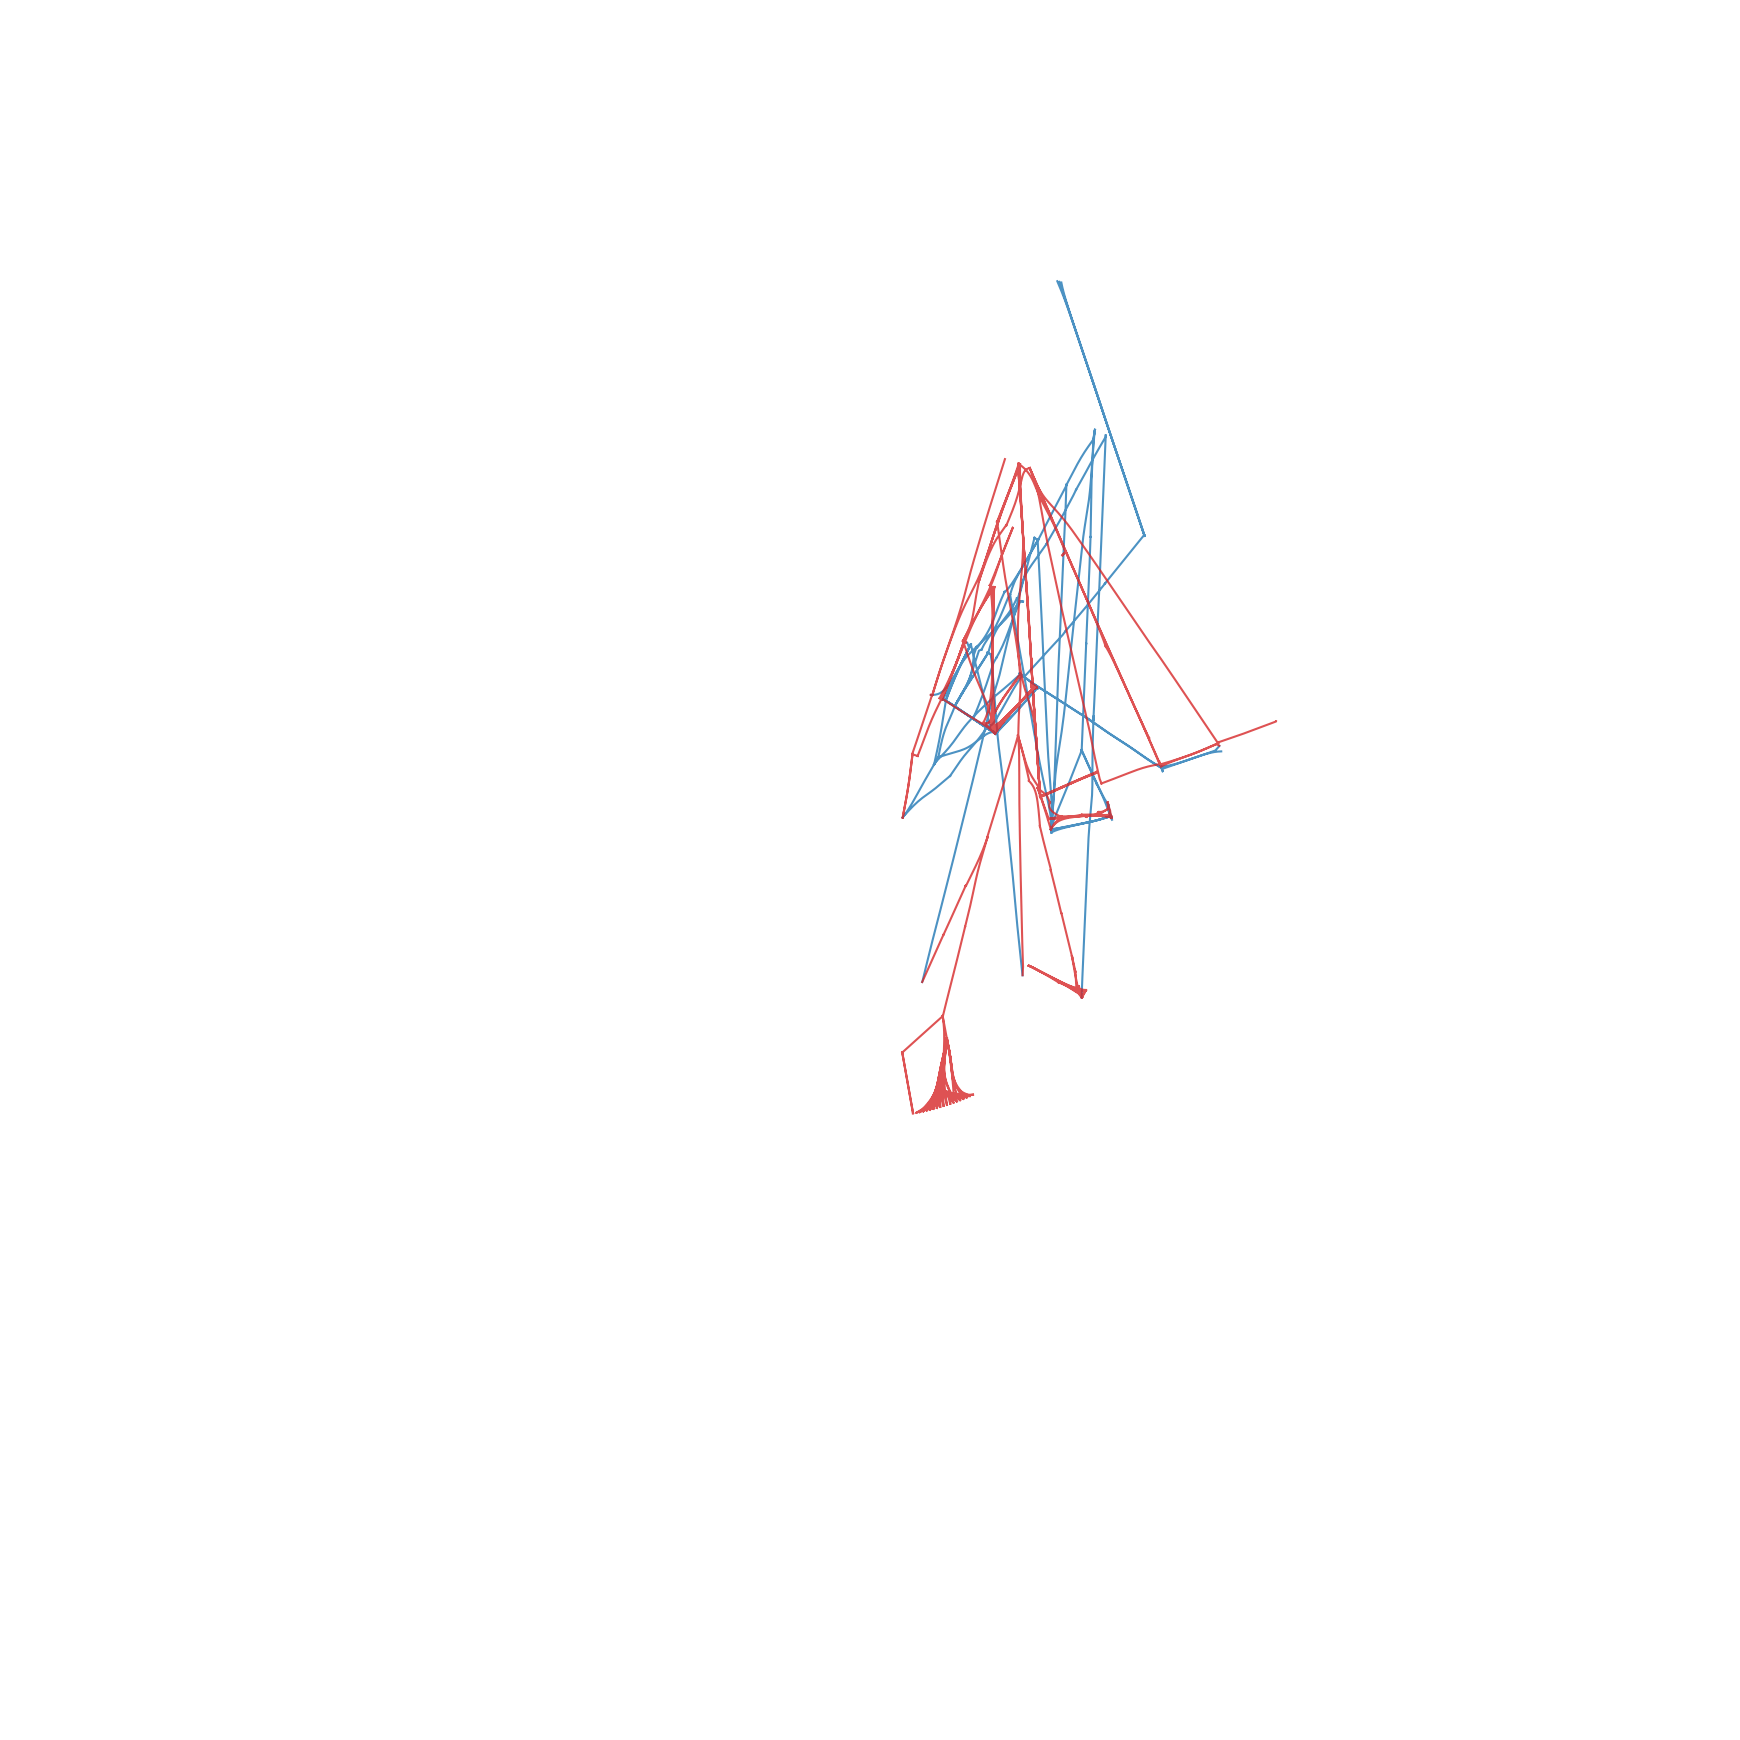

In [96]:
get_coordinates_for_blood_nodes(coordinates_of_nodes_fem, only_female=True, bundle_edges=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_39652\287542985.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruned_blood_nodes['coordinates'] = pruned_blood_nodes['graph_int_id'].apply(lambda x: coordinates_of_nodes[x] if x in coordinates_of_nodes else np.nan)


Fig saved as "./viz_v2.0/blood_viz_male_bundled.svg"


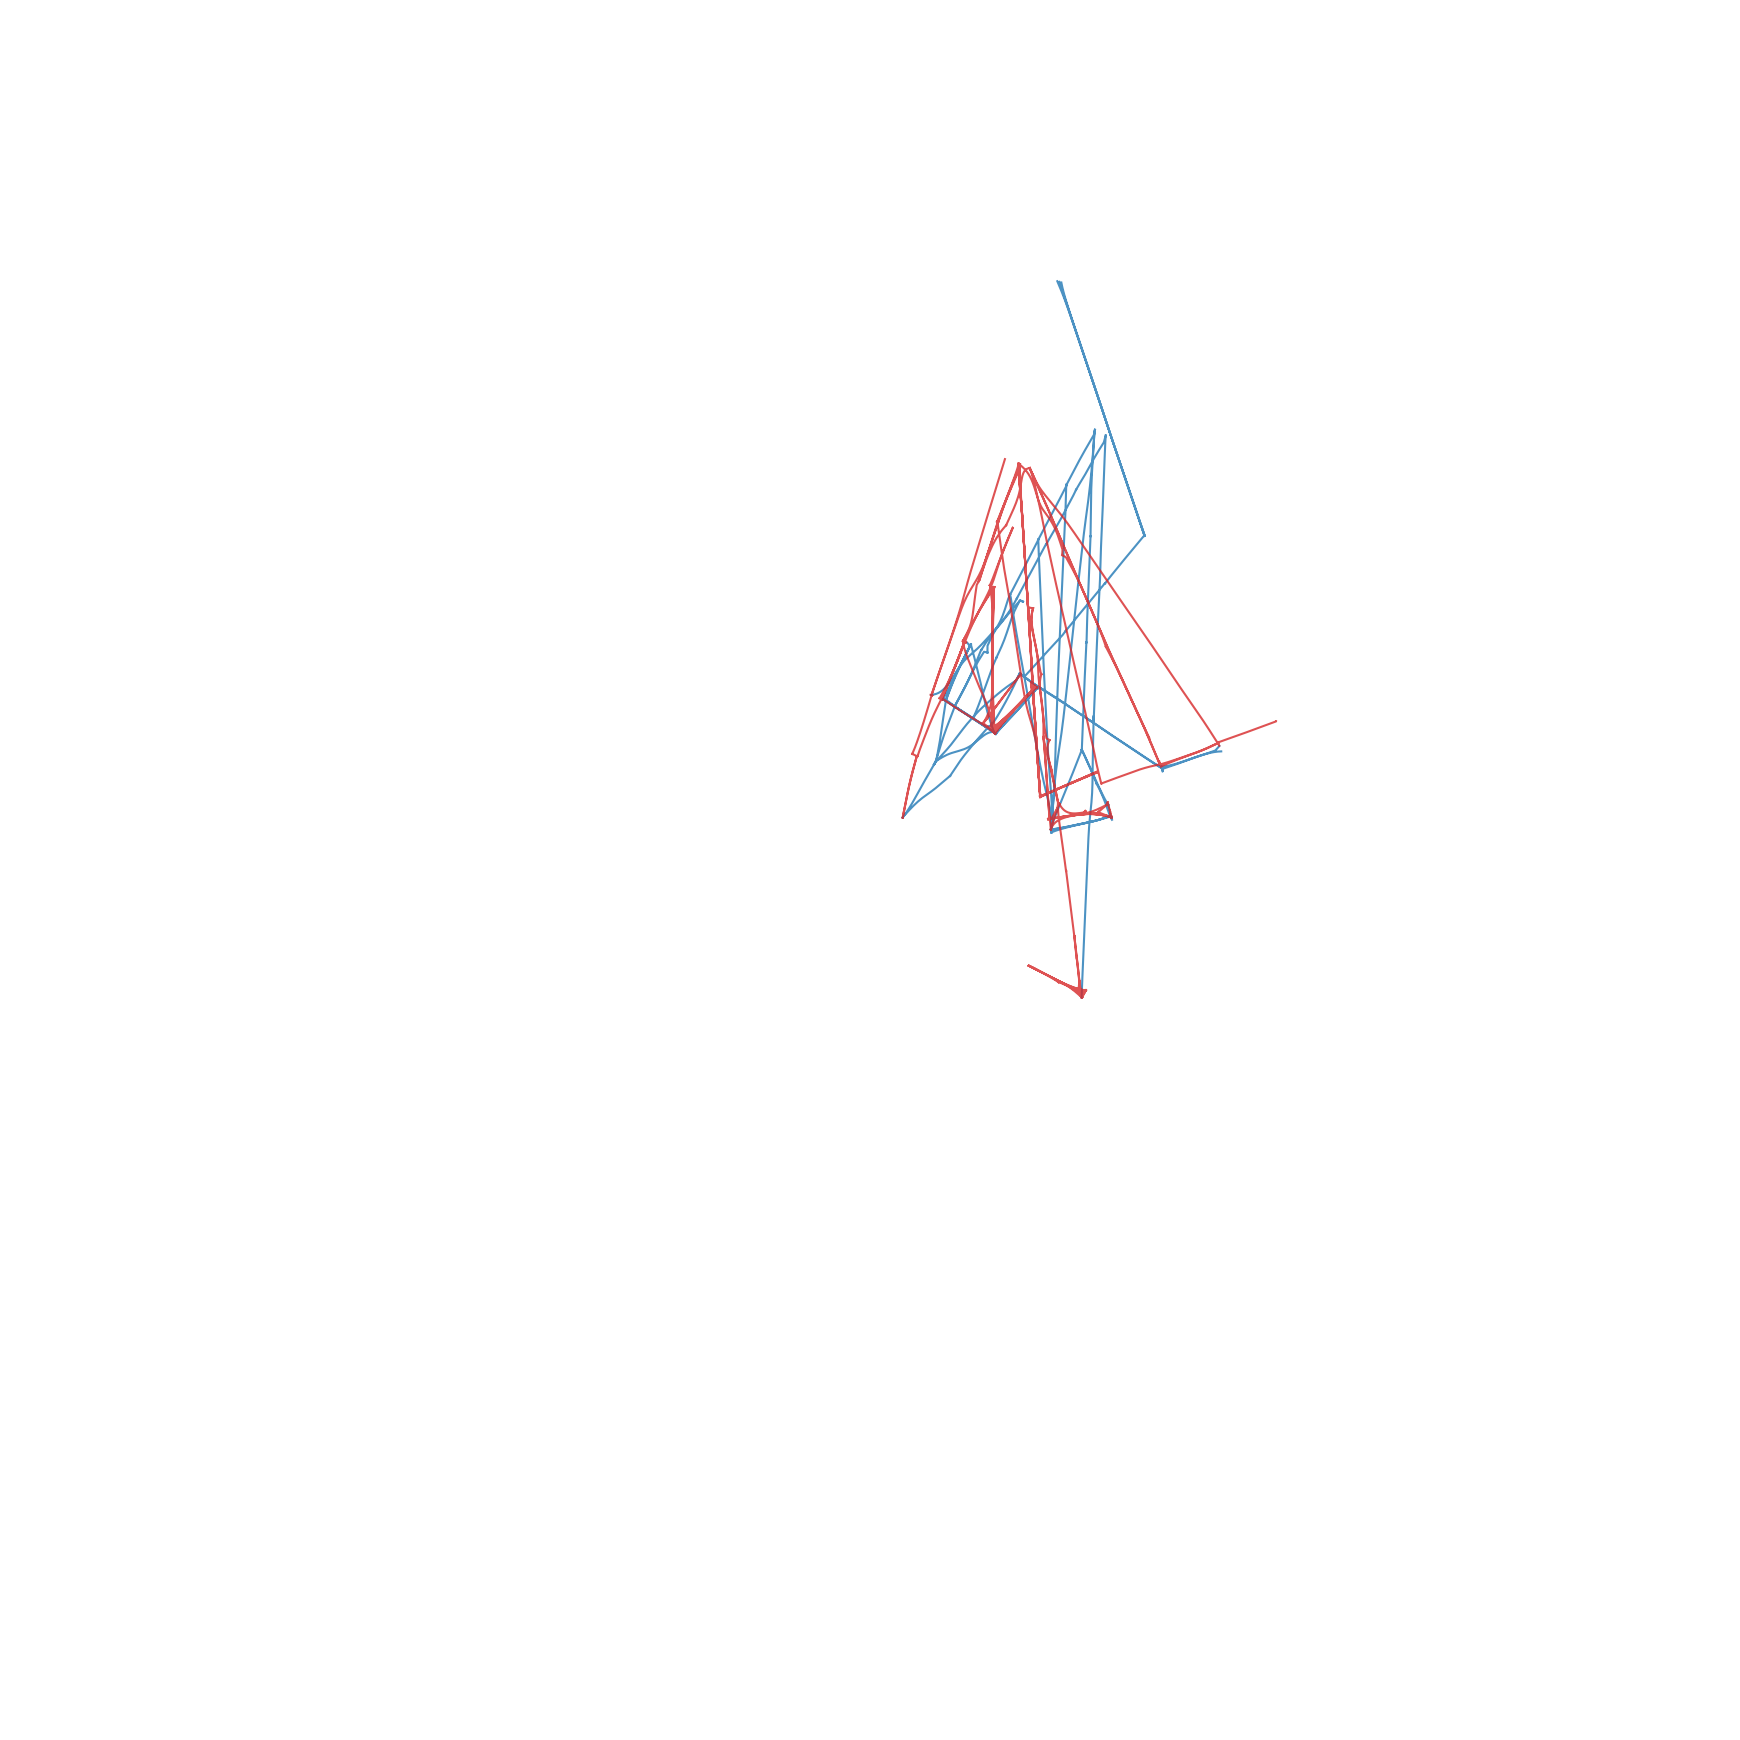

In [97]:
get_coordinates_for_blood_nodes(coordinates_of_nodes_fem, only_male=True, bundle_edges=True)

# Overlay the SVG figures using svgutils

In [ ]:
import svgutils.transform as st
# import svgutils

In [100]:
template = st.fromfile('./viz_v2.0/vega_female_viz.svg', )
second_svg = st.fromfile('./viz_v2.0/blood_viz_female_bundled.svg')

In [102]:
print(template.height, template.width) 
print(second_svg.height, second_svg.width) # for some reason the blood viz is not 1720x1720

1720 1720
1238.4pt 1238.4pt


In [103]:
template.set_size(size=('1720', '1720'))
second_svg.set_size(size=('1720', '1720'))  

In [104]:
print(template.height, template.width) 
print(second_svg.height, second_svg.width) 

1720 1720
1720 1720


In [105]:
template.append(second_svg)
template.save('./viz_v2.0/female_butterfly_wing.svg')

In [106]:
template = st.fromfile('./viz_v2.0/vega_male_viz.svg')
template.set_size(size=('1720', '1720'))
second_svg = st.fromfile('./viz_v2.0/blood_viz_male_bundled.svg')
second_svg.set_size(size=('1720', '1720'))

In [107]:
print(template.height, template.width) 
print(second_svg.height, second_svg.width) 

1720 1720
1720 1720


In [108]:
template.append(second_svg)
template.save('./viz_v2.0/male_butterfly_wing.svg')

In [ ]:

# wing = svgutils.compose.SVG('./viz_v2.0/male_butterfly_wing.svg')


In [119]:
# wing_flipped = wing.scale(-1,1)

In [120]:
# figure = svgutils.compose.Figure('1720', '1720', wing_flipped)
# figure.save('./viz_v2.0/male_butterfly_wing_flipped.svg')